In [1]:
import cupy
import cupyx
import numpy as np
from matplotlib import pyplot as plt
import os
from FastMediumWell import gcf, corrfun

cupy.cuda.Device().synchronize()
cupy._default_memory_pool.free_all_blocks()
# auto reload 
%load_ext autoreload
%autoreload 2

In [2]:
datanpz = np.load('data/uvw_stokesI.npz')

# uvw = uvw, scan=scan, flag_I=flag_I, stokes_I=stokes_I
uvw = datanpz['uvw']
scan = datanpz['scan']
flag_I = datanpz['flag_I']
stokes_I = datanpz['stokes_I']



In [3]:
src = 'src/funcGridding.cu'
dir_src = os.path.dirname(os.path.realpath(src))

griddingFuncSrc = open(src, 'rt')
griddingSimple = cupy.RawModule(code=griddingFuncSrc.read(), backend='nvcc',options=("-I "+dir_src,))
griddingFun = griddingSimple.get_function("SimpleGridding")
griddingFunBatch = griddingSimple.get_function("SimpleGriddingBatch")

In [308]:
process_idx = 1
# how many scan
scan_unique = np.unique(scan)
#for this_scan in scan_unique:
#    ind = np.where(scan == this_scan)[0]
    #plt.plot(uvw[0,ind], uvw[1,ind], 'o')
ind = np.where(scan == process_idx)[0]

uvw_this_scan = uvw[:,ind]
stokes_I_this_scan = stokes_I[ind]

u_inp = uvw_this_scan[0,:]
v_inp = uvw_this_scan[1,:]

I_real = stokes_I_this_scan.real
I_imag = stokes_I_this_scan.imag

image_size = 256
cell =  60 # asec

nx = np.int32(3*image_size)
n_offset = np.int32((nx-image_size)/2)
arc2rad = np.float32(np.pi / 180. / 3600.)

umax = np.max(np.abs(u_inp))
vmax = np.max(np.abs(v_inp))

du = np.float32(1. / (arc2rad * cell)) / (image_size * 2.)

n_umax = np.int32(np.ceil(umax / du))
n_vmax = np.int32(np.ceil(vmax / du))

In [309]:
uvw[:,0]  - uvw[:,1176*90]

array([0., 0., 0.])

In [310]:
vmax

505.6758234544237

In [311]:
gcount = u_inp.shape[0]

/tmp/ipykernel_732537/1638156754.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(convGridFuncTab)), 'o')


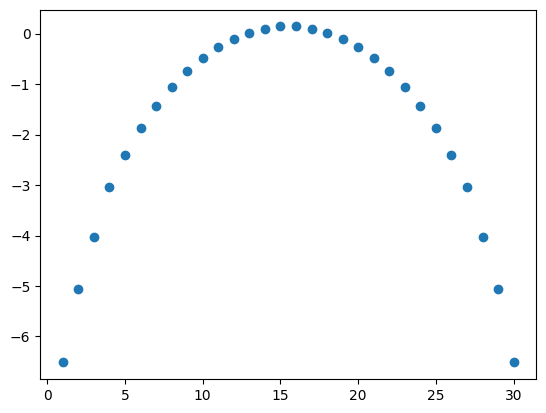

In [312]:
from FastMediumWell import gcf


WIDTH= 8
NCGF= 32
HWIDTH= 4
convGridFuncTab = gcf(NCGF, WIDTH)
plt.plot(np.log(np.abs(convGridFuncTab)), 'o')



# Schwab 1984

In [313]:
blocksize_2D = (8, 16, 1)
gridsize_2D = (np.int32(np.ceil(1. * nx / blocksize_2D[0])),1)
batch_img = np.int32(np.ceil(1. * nx / blocksize_2D[1]))



In [314]:
d_grd = cupy.zeros((np.int32(nx), np.int32(nx)), np.complex64)
d_ngrd = cupy.zeros_like(d_grd)
d_bm = cupy.zeros_like(d_grd)
d_nbm = cupy.zeros_like(d_grd)
d_cbm = cupy.zeros_like(d_grd)

d_u = cupy.asarray(u_inp, dtype=cupy.float32)
d_v = cupy.asarray(v_inp, dtype=cupy.float32)
d_re = cupy.asarray(I_real, dtype=cupy.float32)
d_im = cupy.asarray(I_imag, dtype=cupy.float32)
d_cnt = cupy.zeros_like(d_grd, dtype=cupy.int32)

d_gcf = cupy.asarray(convGridFuncTab, dtype=cupy.float32)

du = cupy.float32(du)

In [315]:
blocksize_2D

(8, 16, 1)

In [316]:
for n in range(1):
    griddingFun(gridsize_2D, blocksize_2D,
               (d_grd,d_bm, d_cbm, d_cnt, d_u, d_v, d_re, d_im,
                d_gcf, WIDTH,  HWIDTH, NCGF, nx, du, gcount, n_umax, n_vmax, batch_img))
# synchronize
cupy.cuda.Device().synchronize()

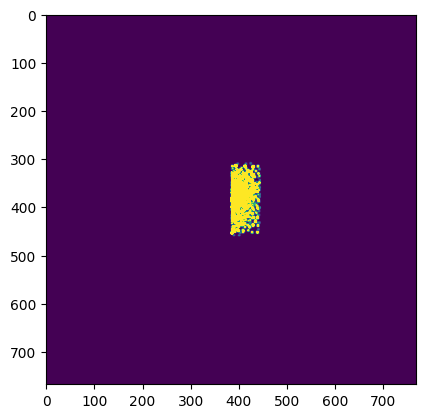

In [317]:
plt.imshow((np.abs(d_grd.get())),vmax=30e3)


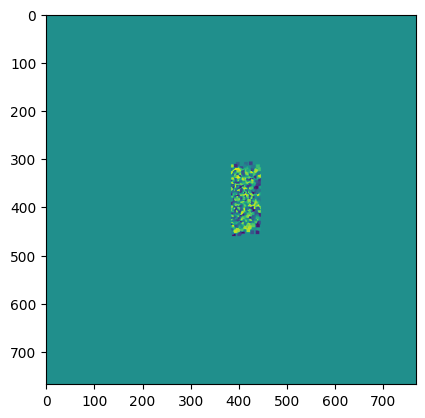

In [318]:
plt.imshow((np.angle(d_grd.get())))

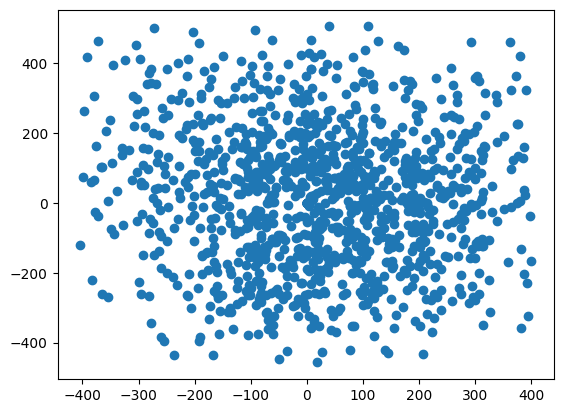

In [319]:
plt.plot(u_inp, v_inp, 'o')

In [320]:
u_inp.shape

(1176,)

In [321]:
import sys
sys.getsizeof(d_grd.get())/8/1024/1024 # MB  per 256*256 complex64

0.5625152587890625

In [322]:
batch_vis = 100


In [323]:
d_grd    = cupy.zeros((np.int32(nx), np.int32(nx)), np.complex64)
d_grd_3d = cupy.zeros((batch_vis, np.int32(nx), np.int32(nx)), np.complex64)

d_ngrd = cupy.zeros_like(d_grd)
d_bm = cupy.zeros_like(d_grd)
d_nbm = cupy.zeros_like(d_grd)
d_cbm = cupy.zeros_like(d_grd)
d_cnt = cupy.zeros_like(d_grd, dtype=cupy.int32)

d_u = cupy.asarray(u_inp, dtype=cupy.float32)
d_v = cupy.asarray(v_inp, dtype=cupy.float32)
d_gcf = cupy.asarray(convGridFuncTab, dtype=cupy.float32)
cupy.cuda.Device().synchronize()

In [324]:
stokes_I_reorder = stokes_I # stokes_I.reshape(100,1176).T.flatten()
d_re_2d = cupy.asarray(stokes_I_reorder.real, dtype=cupy.float32)
d_im_2d = cupy.asarray(stokes_I_reorder.imag, dtype=cupy.float32)

In [325]:
gcount_total=d_re_2d.shape[0]

In [326]:
src = 'src/funcGridding.cu'
dir_src = os.path.dirname(os.path.realpath(src))

griddingFuncSrc = open(src, 'rt')
griddingSimple = cupy.RawModule(code=griddingFuncSrc.read(), backend='nvcc',options=("-I "+dir_src,))
SimpleGridding = griddingSimple.get_function("SimpleGridding")
SimpleGriddingBatch = griddingSimple.get_function("SimpleGriddingBatch")

In [327]:
batch_vis
d_flag = cupy.asarray(flag_I, dtype=cupy.float32)

d_grd_3d[50,nx//2,nx//2]

array(0.+0.j, dtype=complex64)

In [328]:

d_flag

array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [329]:

SimpleGriddingBatch(gridsize_2D, blocksize_2D,
                (d_grd_3d, d_flag,
                d_bm, d_cbm, d_cnt, d_u, d_v, d_re_2d, d_im_2d,
                d_gcf, WIDTH,  HWIDTH, NCGF, nx, du, gcount, gcount_total,
                n_umax, n_vmax, batch_img, batch_vis))
cupy.cuda.Device().synchronize()


In [330]:
new_d_grd_3d = cupy.zeros_like(d_grd_3d)
new_d_grd_3d[:,:,:] = d_grd_3d[:,:,:]

new_d_grd_3d[:,:,0:np.int32(nx/2)]=cupy.flip(
    cupy.flip(cupy.conjugate(d_grd_3d),axis=1),
    axis=2)[:,:,0:np.int32(nx/2)]

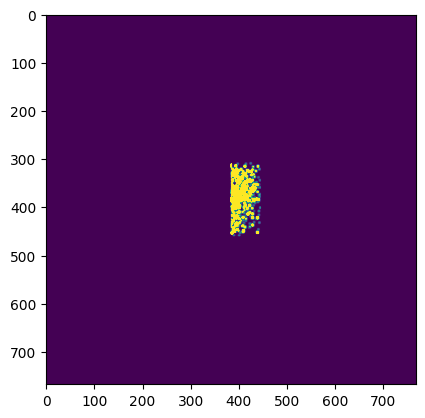

In [331]:
plt.imshow(np.abs(d_grd_3d[8,:,:]).get(),vmax=30e3)

In [332]:
mask_center  = cupy.ones_like(d_grd_3d[0,:,:],dtype=cupy.float32)
xx,yy = cupy.meshgrid(cupy.arange(nx),cupy.arange(nx))
mask_center[cupy.sqrt((xx-nx/2)**2 + (yy-nx/2)**2) < 10] = 0

In [333]:
d_corr = corrfun(nx, WIDTH)
corr2d  = cupy.max(d_corr)**2/ ( cupy.tile(d_corr,(nx,1)) * cupy.tile(d_corr,(nx,1)).T )



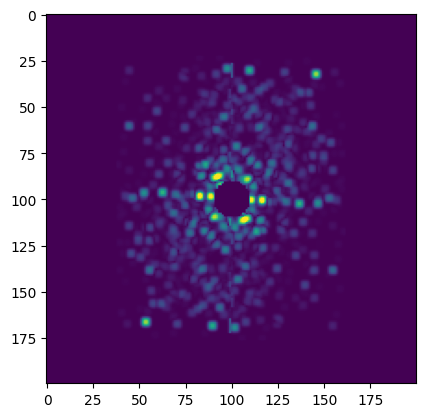

In [334]:
import cupy as cp
from cupyx.scipy.fft import get_fft_plan
import cupyx.scipy.fft

for i in range(100):
    new_d_grd_3d[i,:,:] = new_d_grd_3d[i,:,:]*mask_center*corr2d

plt.imshow(np.abs(new_d_grd_3d[29,(nx//2-100):(nx//2+100),(nx//2-100):(nx//2+100)]).get(),vmax=1e6)

In [335]:
# fftshift before fft
new_d_grd_3d = cupy.fft.fftshift(new_d_grd_3d, axes=(1, 2))

plan = get_fft_plan(new_d_grd_3d, axes=(1, 2), value_type='C2C')

for n in range(1):
    out = cupyx.scipy.fft.ifft2(new_d_grd_3d, axes=(1, 2), plan=plan)

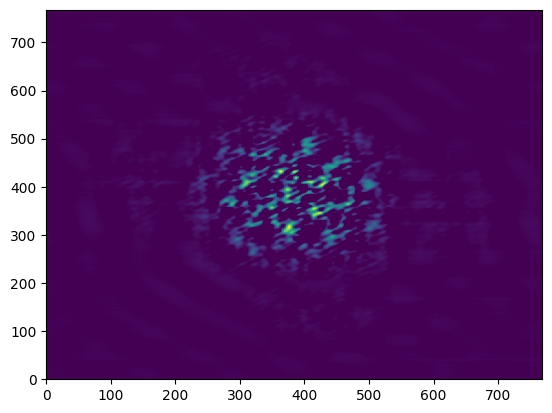

In [336]:
plt.pcolormesh(np.fft.fftshift(np.real(out[2,:,:].get())), vmin=0)
#plt.xlim(500,512+90)
#plt.ylim(500,512+90)

In [337]:
#ToDo: flagging, weighting apply

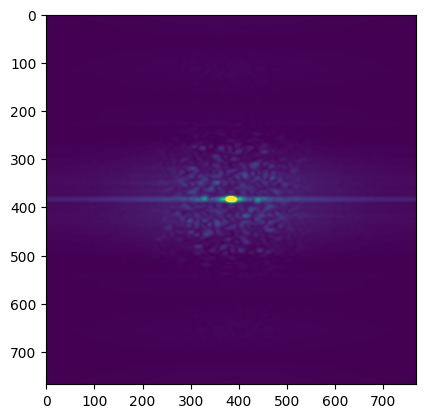

In [339]:
plt.imshow(np.fft.fftshift(np.abs(cupy.fft.fft2((d_bm)).get())),vmax=1e4)

In [78]:
d_flag.device

<CUDA Device 0>